In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

In [2]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("csv/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)

In [3]:
import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"
stocks = ["BTC-USD"]
keywords = {"BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
df_financial = df_financial["Close"]

### Split sentences

In [27]:
articles = df.maintext
articles.index = df["date_google"]

In [28]:
import nltk.data

split_sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [30]:
split_sentences = articles.apply(split_sentence_tokenizer.tokenize)
split_sentences = split_sentences.groupby(split_sentences.index).sum()
split_sentences = pd.DataFrame(split_sentences)

### FullTokenizer

In [25]:
def create_tokenizer(vocab_file='vocab.txt', do_lower_case=False):
    return bert.bert_tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    #Zero Mask till seq_length
    zero_mask = [0] * (max_seq_len-len(tokens))
    input_ids.extend(zero_mask)
    input_mask.extend(zero_mask)
    segment_ids.extend(zero_mask)
    
    return input_ids, input_mask, segment_ids

def convert_sentences_to_features(sentences, tokenizer, max_seq_len=200):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    
    for sentence in sentences:
        input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
        all_input_ids.append(input_ids)
        all_input_mask.append(input_mask)
        all_segment_ids.append(segment_ids)
    
    return all_input_ids, all_input_mask, all_segment_ids

def generate_data_for_tokenizer(split_text,target_series):
    labels_list = []
    dates = []
    for date, arrays in split_text.itertuples():
        dates.extend([date]* len(arrays))
    for date in dates:
        labels_list.append(target_series.loc[date])
    
    split_text_flat = split_text.values.flatten()
    sentence_list = [sentence for array in split_text_flat for sentence in array]
    
    labels = pd.DataFrame(labels_list, index = dates)
    sentences  = pd.DataFrame(sentence_list, index = dates)
    return sentences, labels

In [2]:
BERT_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(BERT_URL, trainable=False)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

tokenizer = create_tokenizer(vocab_file)


In [23]:
def count_words(array):
    return len(array[0].split())

In [31]:
#df_returns = df_financial.pct_change()
df_diff = pd.DataFrame()
df_diff["BTC-USD"] = df_financial - df_financial.shift()

raw_sentences, raw_labels = generate_data_for_tokenizer(split_sentences,df_diff["BTC-USD"])

lengths = raw_sentences.apply(count_words, axis = 1)
sentences = raw_sentences[(lengths > 10) & (lengths < 120)] #filter short and long sentences
labels = raw_labels[(lengths > 10) & (lengths < 120)]

threshold = "2020-01-01"
train_sentences = sentences.loc[:"2019-12-31"]
test_sentences = sentences.loc["2020-01-01":]
train_labels = labels.loc[:"2019-12-31"]
test_labels = labels.loc["2020-01-01":]

In [365]:
print(len(filtered_lengths) == train_sentences.shape[0] + test_sentences.shape[0])
train_lengths = filtered_lengths[:train_sentences.shape[0]]
test_lengths = filtered_lengths[train_sentences.shape[0] + 1:]
print(len(train_lengths))
print(len(test_lengths))

True


[]

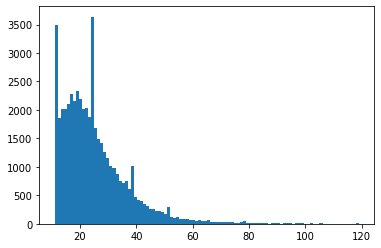

In [89]:
filtered_lengths = lengths[(lengths > 10) & (lengths < 120)]
plt.hist(filtered_lengths, bins = 100)
plt.plot()

In [223]:
train_sentences.shape

(40522, 1)

In [90]:
train_input_ids, train_input_masks, train_segment_ids = convert_sentences_to_features(train_sentences.values.flatten(), tokenizer, 120)
test_input_ids, test_input_masks, test_segment_ids = convert_sentences_to_features(test_sentences.values.flatten(), tokenizer, 120)


In [95]:
train_inputs = {
     "input_ids": np.array(train_input_ids),
     "input_mask": np.array(train_input_masks),
     "segment_ids": np.array(train_segment_ids),
     }
test_inputs = {
     "input_ids": np.array(test_input_ids, dtype = 'int64'),
     "input_mask": np.array(test_input_masks, dtype = 'int64'),
     "segment_ids": np.array(test_segment_ids, dtype = 'int64'),
     }

In [ ]:
for k in test_inputs:
    test_inputs[k] = tf.cast(test_inputs[k], tf.int32)

### BERT output

In [92]:
max_seq_length = 120
# Build model
in_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
in_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
in_segment = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]

# Instantiate the custom Bert Layer defined above
pooled_output, sequence_output = bert_layer(inputs = bert_inputs)
bert_outputs = [pooled_output, sequence_output]
bert_model = tf.keras.models.Model(inputs=bert_inputs, outputs=bert_outputs)
bert_model.compile(loss='mean_squared_error', optimizer='adam')

In [96]:
train_bert_output = bert_model.predict(train_inputs, batch_size=256)

In [97]:
test_bert_output = bert_model.predict(test_inputs, batch_size=256)

In [98]:
len(train_bert_output)

2

In [105]:
np.save("train_bert_output_pooled",train_bert_output[0])
np.save("train_bert_output_sequence",train_bert_output[1])
np.save("test_bert_output_pooled",test_bert_output[0])
np.save("test_bert_output_sequence",test_bert_output[1])

In [115]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [125]:
from random import randint
randint(0, 768)

314

In [140]:
train_bert_output[0].shape

(40522, 768)

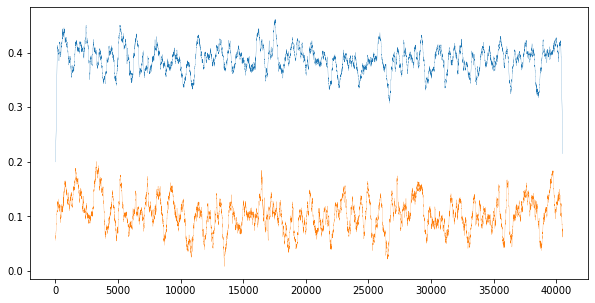

In [222]:
max_ = 768 # 40522
i = randint(0, max_)
i2 = randint(0, max_)
s = train_bert_output[0][:,i]
s2 = train_bert_output[0][:,i + 1]

plt.figure(figsize=(10, 5))
plt.plot(smooth(s,300), '-', lw=0.2)
plt.plot(smooth(s2,300), '-', lw=0.2)


In [277]:
filtered_lengths

2019-01-01    20
2019-01-01    23
2019-01-01    21
2019-01-01    29
2019-01-01    17
              ..
2020-03-19    28
2020-03-19    33
2020-03-19    14
2020-03-19    26
2020-03-19    38
Length: 48947, dtype: int64

In [266]:
train_bert_output[1].shape

(40522, 120, 768)

In [298]:
print(train_inputs["input_ids"].shape)
print(train_inputs["input_mask"].shape)
print(train_inputs["segment_ids"].shape)

(40522, 120)
(40522, 120)
(40522, 120)


Sentence ['Cryptocurrency exchange HitBTC has frozen its customers’ accounts ahead of an annual proof of keys event, according to multiple sources.']
Text number of words:  20 20
Text number of tokens:  25

input_ids 
 [ 101  100 3863  100 2038 7708 2049 6304 1521 6115 3805 1997 2019 3296
 6947 1997 6309 2724 1010 2429 2000 3674 4216 1012  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
input_mask 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

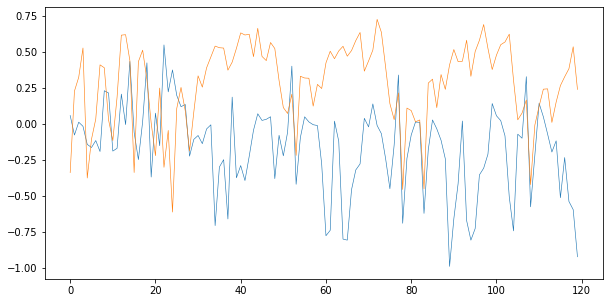

In [326]:
i = 0#randint(0, 40522)
text = train_sentences.values[i]
print("Sentence",text)
print("Text number of words: ",filtered_lengths[i], len(text[0].split(" ")))
print("Text number of tokens: ", train_inputs["input_mask"][i].sum())
print("\ninput_ids \n",train_inputs["input_ids"][i])
print("input_mask \n",train_inputs["input_mask"][i])
print("segment_ids \n",train_inputs["segment_ids"][i])

_120_1 = train_bert_output[1][i,:,1]
_120_2 = train_bert_output[1][i,:,2]
plt.figure(figsize=(10, 5))
plt.plot(smooth(_120_1,1), '-', lw=0.6)
plt.plot(smooth(_120_2,1), '-', lw=0.6)

In [334]:
test_bert_output[1][n_tokens].shape

(40522, 120, 768)

In [355]:
train_n_tokens = train_inputs["input_mask"][:].sum(axis = 1)
train_mask_out = [train_bert_output[1][counter,:length,:] for length, counter in zip(train_n_tokens,range(len(train_n_tokens)))]
test_n_tokens = test_inputs["input_mask"][:].sum(axis = 1)
test_mask_out = [test_bert_output[1][counter,:length,:] for length, counter in zip(test_n_tokens,range(len(test_n_tokens)))]

In [368]:
print(train_sentences.shape)
train_n_sentences = train_sentences.groupby(train_sentences.index).count()
print(test_sentences.shape)
test_n_sentences = test_sentences.groupby(test_sentences.index).count()

(40522, 1)
(8425, 1)


In [474]:
def bert_output_to_one_time_series_per_day(mask_out, n_sentences):
    articles_per_day = []
    acc = 0
    for n in n_sentences.values:
        n = n[0]
        concat_articles = np.array(mask_out[acc:acc + n])
        flattened = []
        for sentence in concat_articles:
            for token in sentence:
                flattened.append(token)
        flattened = np.array(flattened)
        #flattened = np.array([token for token in sentence for sentence in concat_articles])
        articles_per_day.append(flattened)
        acc += n
    return np.array(articles_per_day)

In [475]:
train_bert_concat_articles = bert_output_to_one_time_series_per_day(train_mask_out, train_n_sentences)
test_bert_concat_articles = bert_output_to_one_time_series_per_day(test_mask_out, test_n_sentences)

In [486]:
np.save("train_bert_concat_articles",train_bert_concat_articles)
np.save("test_bert_concat_articles",test_bert_concat_articles)
train_labels.to_pickle("train_labels")
test_labels.to_pickle("test_labels")

25 31


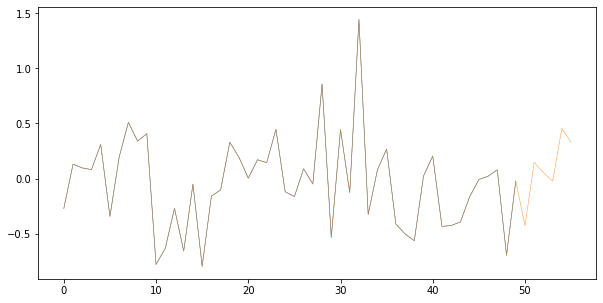

In [485]:
i = 0
mask_i = train_inputs["input_mask"][i].sum()
mask_i1 = train_inputs["input_mask"][i + 1].sum()
print(mask_i,mask_i1)
masked_sentence = train_bert_output[1][i,:mask_i,0]
masked_sentence1 = train_bert_output[1][i+1,:mask_i,0]
concat = np.append(masked_sentence,masked_sentence1)
plt.figure(figsize=(10, 5))
plt.plot(concat, '-', lw=0.6)
plt.plot(train_bert_concat_articles[0][:mask_i + mask_i1,0], '-', lw=0.4)

## LSTM

- https://ieeexplore.ieee.org/document/8141873
- https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
import pandas as pd, numpy as np

In [3]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [4]:
train_bert_concat_articles = np.load("train_bert_concat_articles.npy")
test_bert_concat_articles  = np.load("test_bert_concat_articles.npy")

In [5]:
np.load = np_load_old

In [6]:
train_labels = pd.read_pickle("train_labels")
test_labels = pd.read_pickle("test_labels")

In [8]:
def my_own_pad_sequence(array, maxlen):
    X_tr = []
    for x in array:
        length =  x.shape[0]
        if length > maxlen:
            X_tr.append(x[:maxlen])
        else:
            pad_diff = maxlen - length
            x = np.vstack((x, np.zeros([pad_diff,x.shape[1]])))
            X_tr.append(x)
    return np.array(X_tr)    
    

In [18]:
maxlen = 3000
X_train_tr = my_own_pad_sequence(train_bert_concat_articles, maxlen)
X_test_tr = my_own_pad_sequence(test_bert_concat_articles, maxlen)
y_train = train_labels
y_test = test_labels

In [10]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [11]:
from tensorflow.keras.layers import LSTM, CuDNNLSTM, Dense, Input
from tensorflow.keras.models import Sequential

In [19]:
# create the model
#n_steps = 50
n_features = 768
model = Sequential()
#model.add(CuDNNLSTM(200, input_shape=(None, n_features), return_sequences= True))
model.add(CuDNNLSTM(200, input_shape=(None, n_features)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 200)               776000    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 786,101
Trainable params: 786,101
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history = model.fit(X_train_tr, y_train, validation_data=(X_test_tr, y_test), epochs=5, batch_size=1)

Train on 364 samples, validate on 78 samples
Epoch 1/5
364/364 [==============================] - 18s 50ms/sample - loss: 100101.0771 - val_loss: 186927.9485
Epoch 2/5
364/364 [==============================] - 14s 39ms/sample - loss: 99674.0856 - val_loss: 187989.5533 983
Epoch 3/5
364/364 [==============================] - 14s 39ms/sample - loss: 98664.8698 - val_loss: 190151.3625
Epoch 4/5
364/364 [==============================] - 14s 39ms/sample - loss: 96687.1134 - val_loss: 191287.7435
Epoch 5/5
364/364 [==============================] - 14s 39ms/sample - loss: 91767.0199 - val_loss: 198804.4405


# DRAFTS

In [32]:

train_labels = df_diff["BTC-USD"].loc[:"2019-12-31"]
test_labels = df_diff["BTC-USD"].loc["2020-01-01":]
train_labels = train_labels[pd.DatetimeIndex(train_sentences.groupby(train_sentences.index).count().index)]
test_labels = test_labels[pd.DatetimeIndex(test_sentences.groupby(test_sentences.index).count().index)]
assert test_labels.shape == test_bert_concat_articles.shape
assert train_labels.shape == train_bert_concat_articles.shape

In [585]:
d = np.arange(10000).reshape(100,5,2,2,5)
d.strides

(400, 80, 40, 20, 4)

In [611]:
result = np.array([])   
for i in range(0,10):
    result = np.append(result, np.array([i]*5))
result = result.reshape(10,5)
rolling_window_bert_2nd_dim(result,8)

In [10]:
def rolling_window_bert_2nd_dim(a, window):
    shape = (a.shape[0] - window + 1, window, a.shape[1])
    strides = (a.strides[0], a.strides[1]*a.shape[1], a.strides[1])
    #print(shape, strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [92]:
#window = 100
#X_train = [rolling_window_bert_2nd_dim(element, window) for element in train_bert_concat_articles]
#X_test = [rolling_window_bert_2nd_dim(element, window) for element in test_bert_concat_articles]
#y_train = train_labels
#y_test = test_labels

In [102]:

#X_train_tr= pad_sequences(train_bert_concat_articles, maxlen=maxlen, padding='post', truncating='post')

In [155]:
X_train_tr = my_own_pad_sequence(train_bert_concat_articles, maxlen)
X_test_tr = my_own_pad_sequence(test_bert_concat_articles, maxlen)

In [82]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 5000
X_train_tr= pad_sequences(X_train, maxlen=maxlen, truncating='post')
X_test_tr= pad_sequences(X_test, maxlen=maxlen, truncating='post')



(array([  5.,  46., 104., 109.,  50.,  22.,  19.,   5.,   1.,   1.,   1.,
          0.,   0.,   0.,   1.]),
 array([ 1478.        ,  2177.26666667,  2876.53333333,  3575.8       ,
         4275.06666667,  4974.33333333,  5673.6       ,  6372.86666667,
         7072.13333333,  7771.4       ,  8470.66666667,  9169.93333333,
         9869.2       , 10568.46666667, 11267.73333333, 11967.        ]),
 <a list of 15 Patch objects>)

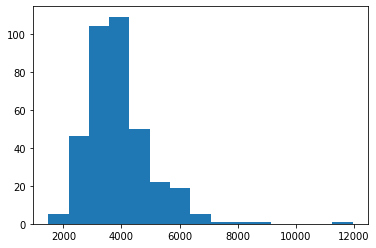

In [63]:
plt.hist(lengths, bins = 15,)